## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
%load_ext lab_black
from src.perspective import Calibration
import glob
import cv2
import numpy as np

# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from main import LaneDetectionPipeline

test model calibration

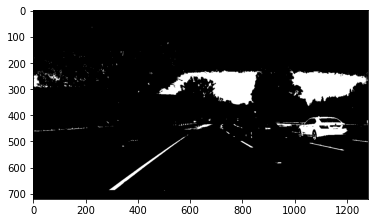

In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

image = mpimg.imread("test_images/test6.jpg")
thresh = (180, 255)
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
binary1 = np.zeros_like(gray)
binary1[(gray > thresh[0]) & (gray <= thresh[1])] = 1
plt.imshow(binary1, cmap="gray")

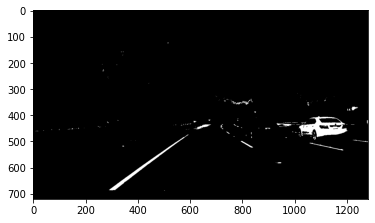

In [3]:
R = image[:, :, 0]
G = image[:, :, 1]
B = image[:, :, 2]

thresh = (200, 255)
binary2 = np.zeros_like(R)
binary2[(R > thresh[0]) & (R <= thresh[1])] = 1
plt.imshow(binary2, cmap="gray")

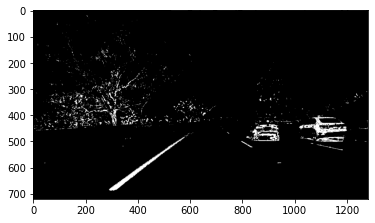

In [4]:
hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
H = hls[:, :, 0]
L = hls[:, :, 1]
S = hls[:, :, 2]

thresh = (150, 255)
binary3 = np.zeros_like(S)
binary3[(S > thresh[0]) & (S <= thresh[1])] = 1
plt.imshow(binary3, cmap="gray")

In [5]:
from src.perspective import Calibration
from src.line import LaneDetection, Line
from src.filters import ColorFiltering, GradientFiltering
from src.annotate import AnnotateFrame
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob


def process_frame(
    img,
    gradient_params,
    color_params,
    lane_detect_params,
    annotate_params,
):
    """ pipeline that process and annotate a single frame """

    # apply color filters
    color = ColorFiltering(**color_params)
    color_filtered_img = color.apply_color_filter(img)

    # apply gradient filters
    gradient = GradientFiltering(**gradient_params)
    gradient_filtered_img = gradient.apply_gradient_filter(img)

    # combine gradient and color filter
    combined_filtered_image = np.logical_or(
        color_filtered_img, gradient_filtered_img
    ).astype(np.uint8)

    # calibrate the carmera
    perspective_transformer = Calibration()
    perspective_transformer.set_calibration()
    # undistort and convert image to bird's eye view
    birdeye_filtered_img = perspective_transformer.undistort_and_birdeye_transform(
        combined_filtered_image
    )
    birdeye_original_img = perspective_transformer.undistort_and_birdeye_transform(img)

    # instantiate 2 line objects
    global left_lane, right_lane

    left_lane = Line()
    right_lane = Line()

    # detect lanes
    left_lane, right_lane, img_fit = LaneDetection(
        img=birdeye_filtered_img,
        left_lane=Line(),
        right_lane=Line(),
        **lane_detect_params,
    ).detect(0)
    # annotate frame
    annotate = AnnotateFrame(
        left_lane,
        right_lane,
        img_assets=[
            img,
            birdeye_original_img,
            combined_filtered_image,
            birdeye_filtered_img,
            img_fit,
        ],
        perspective_transformer=perspective_transformer,
        **annotate_params,
    )
    # produce the final blended frame
    res_frame = annotate.blend_frame()

    return (
        color_filtered_img,
        gradient_filtered_img,
        combined_filtered_image,
        birdeye_filtered_img,
        birdeye_original_img,
        left_lane,
        right_lane,
        img_fit,
        res_frame,
    )

## And so on and so forth...

In [6]:
test_img = glob.glob("test_images/*.jpg")[2]
img = cv2.imread(test_img)
(
    color_filtered_img,
    gradient_filtered_img,
    combined_filtered_image,
    birdeye_filtered_img,
    birdeye_original_img,
    left_lane,
    right_lane,
    img_fit,
    res_frame,
) = process_frame(
    img,
    gradient_params=dict(
        sobel_kernel_size=3,
        sobel_threshold=(20, 100),
        magnitude_threshold=(50, 255),
        direction_threshold=(0.7, 1.3),
    ),
    color_params=dict(s_thresholds=(150, 255), r_thresholds=(200, 255)),
    lane_detect_params=dict(
        num_windows=9,
        window_margin=50,
        min_pixels=50,
        fit_tolerance=100,
    ),
    annotate_params=dict(
        line_width=50,
        lane_colors=[(0, 0, 255), (255, 0, 0)],
        road_region_color=(0, 255, 0),
    ),
)

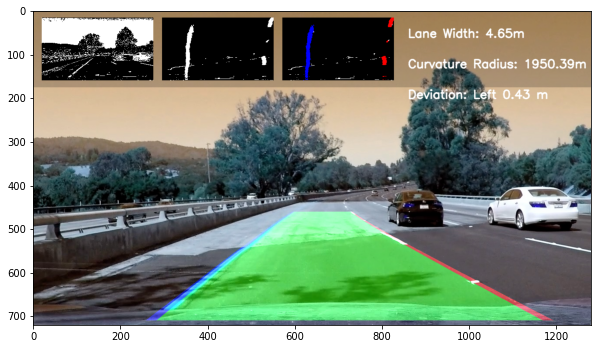

In [7]:
plt.figure(figsize=(10, 7))
plt.imshow(res_frame)

Test on videos

In [8]:
lane = LaneDetectionPipeline(
    gradient_params=dict(
        sobel_kernel_size=5,
        sobel_threshold=(70, 100),
        magnitude_threshold=(120, 255),
        direction_threshold=(0.7, 1.3),
    ),
    color_params=dict(s_thresholds=(150, 255), r_thresholds=(200, 255)),
    lane_detect_params=dict(
        num_windows=9,
        window_margin=50,
        min_pixels=50,
        fit_tolerance=100,
    ),
    annotate_params=dict(
        line_width=50,
        lane_colors=[(0, 0, 255), (255, 0, 0)],
        road_region_color=(0, 255, 0),
    ),
)

project_output = "test_videos_output/project_video.mp4"

clip3 = VideoFileClip("test_videos/project_video.mp4")
project_clip = clip3.fl_image(lane.process_frame)
%time project_clip.write_videofile(project_output, audio=False)

t:   0%|          | 2/1260 [00:00<01:40, 12.49it/s, now=None]

Moviepy - Building video test_videos_output/project_video.mp4.
Moviepy - Writing video test_videos_output/project_video.mp4



Moviepy - Done !
Moviepy - video ready test_videos_output/project_video.mp4
CPU times: user 3min 37s, sys: 51.5 s, total: 4min 29s
Wall time: 3min


In [9]:
HTML(
    """
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(
        project_output
    )
)